# Using genetic algorithms to solve the traveling salesperson problem

### Derived from the material by Luis Martí, [IC](http://www.ic.uff.br)/[UFF](http://www.uff.br)

https://github.com/lmarti/evolutionary-computation-course/

# [*Traveling Salesman Problem*](http://en.wikipedia.org/wiki/Traveling_salesman_problem) (TSP): 

> *Given a set of cities, and the distances between each pair of cities, find a **tour** of the cities with the minimum total distance.  A **tour** means you start at one city, visit every other city exactly once, and then return to the starting city.*

### The *vocabulary* of the problem:

- **City**: For the purpose of this exercise, a city is "atomic" in the sense that we don't have to know anything about the components or attributes of a city, just how far it is from other cities.
- **Cities**: We will need to represent a set of cities; Python's `set` datatype might be appropriate for that.
- **Distance**: We will need the distance between two cities.  If `A` and `B` are cities. This could be done with a function, `distance(A, B)`, or with a dict, `distance[A][B]` or `distance[A, B]`, or with an array if `A` and `B` are integer indexes.  The resulting distance will be a real number (which Python calls a `float`).
- **Tour**: A tour is an ordered list of cities; Python's `list` or `tuple` datatypes would work.
- **Total distance**: The sum of the distances of adjacent cities in the tour.  We will probably have a function, `total_distance(tour)`.

We need to perform some initialization.

In [1]:
from deap import algorithms, base, creator, tools
import random, operator
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

### Representing Cities and Distance


Now for the notion of *distance*.  We define `total_distance(tour)` as the sum of the distances between consecutive cities in the tour; that part is shown below and is easy (with one Python-specific trick: when `i` is 0, then `distance(tour[0], tour[-1])` gives us the wrap-around distance between the first and last cities, because `tour[-1]` is the last element of `tour`). 

In [2]:
def distance(A, B):
    "The Euclidean distance between two cities."
    return np.linalg.norm(A - B)

def total_distance(tour):
    "The total distance between each pair of consecutive cities in the tour."
    return sum(distance(tour[i], tour[i-1])
               for i in range(len(tour)))

### Distance between cities 

* **complex:** Python already has the two-dimensional point as a built-in numeric data type, but in a non-obvious way: as *complex numbers*, which inhabit the two-dimensional (real &times; complex) plane. We can make this use more explicit by defining "`City = complex`", meaning that we can construct the representation of a city using the same constructor that makes complex numbers. 

From possible alternatives Peter chose to go with complex numbers. 

In [3]:
City = complex # Constructor for new cities, e.g. City(300, 400)

def generate_cities(n):
    "Make a set of n cities, each with random coordinates."
    return set(City(random.randrange(10, 890),
                    random.randrange(10, 590))
               for c in range(n))

In [4]:
num_cities = 24
cities = generate_cities(num_cities)

This is a typical *NP-Complete* problem. The time for $n$ cities should be roughly proportional to $n!$. This means that the time grows rapidly with the number of cities; we'd need longer than the **[age of the Universe](http://en.wikipedia.org/wiki/Age_of_the_universe)** to run `exact_non_redundant_TSP()` on just 24 cities:

<table>
<tr><th>n cities<th>time
<tr><td>10<td>3 secs
<tr><td>12<td>3 secs &times; 12 &times 11 = 6.6 mins
<tr><td>14<td>6.6 mins &times; 13 &times; 14 = 20 hours
<tr><td>24<td>3 secs &times; 24! / 10! = <a href="https://www.google.com/search?q=3+seconds+*+24!+%2F+10!+in+years">16 billion years</a>
</table>

> There must be a better way... or at least we need to look for it until quantum computing comes around.

# Nature-inspired metaheuristics

- We have seen in class some examples of nature-inspired metaheuristics.
- They are an option in which we dedicate a little more computational effort in order to produce better solutions than `greedy_TSP()`.

> We will be using the [DEAP](https://github.com/DEAP/deap) library to code this tackle this problem using a genetic algorithm.

[<img src='https://raw.githubusercontent.com/DEAP/deap/master/doc/_static/deap_long.png' width='29%' align='center'/>](https://github.com/DEAP/deap)

In [1]:
from deap import algorithms, base, creator, tools

### Elements to take into account solving problems with genetic algorithms

* **Individual representation** (binary, floating-point, etc.);
* **evaluation** and **fitness assignment**;
* **selection**, that establishes a partial order of individuals in the population using their fitness function value as reference and determines the degree at which individuals in the population will take part in the generation of new (offspring) individuals.
* **variation**, that applies a range of evolution-inspired operators, like crossover, mutation, etc., to synthesize offspring individuals from the current (parent) population. This process is supposed to prime the fittest individuals so they play a bigger role in the generation of the offspring.
* **stopping criterion**, that determines when the algorithm shoulod be stopped, either because the optimum was reach or because the optimization process is not progressing.

The `toolbox` stored the setup of the algorithm. It describes the different elements to take into account.

In [6]:
toolbox = base.Toolbox()

### Individual representation and evaluation
* Individuals represent possible solutions to the problem.
* In the TSP case, it looks like the tour itself can be a suitable representation.
* For simplicity, an individual can be a list with the indexes corresponding to each city.
* This will simplify the crossover and mutation operators.
* We can rely on the `total_distance()` function for evaluation and set the fitness assignment as to minimize it.

In [7]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,)) # -1 means that we wish to minimize the fitness
creator.create("Individual", list, fitness=creator.FitnessMin)

Let's now define that our individuals are composed by indexes that referr to elements of `cities` and, correspondingly, the population is composed by individuals.

In [8]:
toolbox.register("indices", np.random.permutation, len(cities))
toolbox.register("individual", tools.initIterate, creator.Individual,
                 toolbox.indices)
toolbox.register("population", tools.initRepeat, list,
                 toolbox.individual)


Defining the crossover and mutation operators can be a challenging task.

There are  various <a href='http://en.wikipedia.org/wiki/Crossover_(genetic_algorithm)#Crossover_for_Ordered_Chromosomes'>crossover operators</a> that have been devised to deal with ordered individuals like ours.

- We will be using DEAP's `deap.tools.cxOrdered()` crossover. This will not leave out any cities during crossover (You don't need to worry about the detail. Nevertheless, if you are interested, think why we cannot use one/two points crossover). 
- For mutation we will swap elements from two points of the individual.
- This is performed by `deap.tools.mutShuffleIndexes()`.

In [9]:
toolbox.register("mate", tools.cxOrdered)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)

Evaluation can be easily defined from the `total_distance()` definition.

In [10]:
def create_tour(individual):
    return [list(cities)[e] for e in individual]

def evaluation(individual):
    '''Evaluates an individual by converting it into
    a list of cities and passing that list to total_distance'''
    return (total_distance(create_tour(individual)),)

In [12]:
toolbox.register("evaluate", evaluation)

We will employ tournament selection with size 3.

In [13]:
toolbox.register("select", tools.selTournament, tournsize=3)

Lets' run the algorithm with a population of 100 individuals and 400 generations.

In [14]:
pop = toolbox.population(n=100)

In [15]:
%%time 
result, log = algorithms.eaSimple(pop, toolbox,
                             cxpb=0.8, mutpb=0.2,
                             ngen=400, verbose=False)

CPU times: user 4.31 s, sys: 50.9 ms, total: 4.36 s
Wall time: 4.47 s


Congratulations! You have just saved 16 billion years of your life :-) 

### We can now review the results

The best individual of the last population:

Fitness of the best individual:  3530.8825091522826


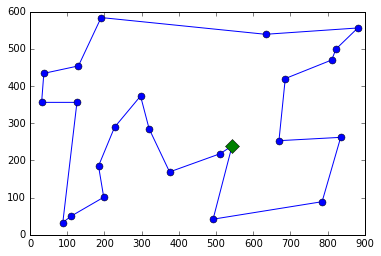

In [17]:
best_individual = tools.selBest(result, k=1)[0]
print('Fitness of the best individual: ', evaluation(best_individual)[0])

def plotline(points, style='bo-', alpha=1, size=7, color=None):
    "Plot a list of points (complex numbers) in the 2-D plane."
    X, Y = XY(points)

    if color:
        plt.plot(X, Y, style, alpha=alpha, markersize=size, color=color)
    else:
        plt.plot(X, Y, style, alpha=alpha, markersize=size)


def XY(points):
    "Given a list of points, return two lists: X coordinates, and Y coordinates."
    return [p.real for p in points], [p.imag for p in points]


def plot_tour(tour, alpha=1, color=None):
    # Plot the tour as blue lines between blue circles, and the starting city as a red square.
    plotline(list(tour) + [tour[0]], alpha=alpha, color=color)
    plotline([tour[0]], style='gD', alpha=alpha, size=10)
    plt.show()
    
plot_tour(create_tour(best_individual))

It is interesting to assess how the fitness of the population changed as the evolution process took place. 

We can prepare an `deap.tools.Statistics` instance to specify what data to collect. 

In [19]:
fit_stats = tools.Statistics(key=operator.attrgetter("fitness.values"))
fit_stats.register('mean', np.mean)
fit_stats.register('min', np.min)

We are all set now but lets run again the genetic algorithm configured to collect the statistics that we want to gather:

In [20]:
result, log = algorithms.eaSimple(toolbox.population(n=100), toolbox,
                                  cxpb=0.8, mutpb=0.2,
                                  ngen=400, verbose=False,
                                  stats=fit_stats)

### Plotting mean and minimium fitness as evolution took place.


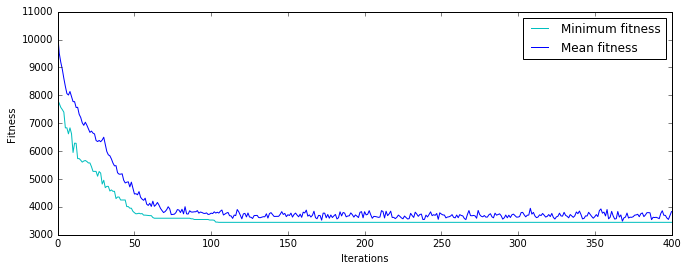

In [21]:
plt.figure(figsize=(11, 4))
plots = plt.plot(log.select('min'),'c-', log.select('mean'), 'b-')
plt.legend(plots, ('Minimum fitness', 'Mean fitness'), frameon=True)
plt.ylabel('Fitness'); plt.xlabel('Iterations');